In [61]:
# import libraries 
# ----------------
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt

In [62]:
# load SU file using obspy 
# ------------------------
from obspy.io.segy.segy import _read_su
vx = _read_su('shot_vx_full_zsource_1800_900.su', endian='<') # recorded vx
vz = _read_su('shot_vz_full_zsource_1800_900.su', endian='<') # recorded vz
# convert them to numpy array
vx = (np.stack(i.data for i in vx.traces)).T
vz = (np.stack(i.data for i in vz.traces)).T

In [57]:
# initialize parameter 
# --------------------
nx = vx.shape[1] # number of cells in x direction
dx = 0.25        # cell size
dt = 5e-6        # time step
alpha = 1800     # P-wave velocity
beta = 900       # S-wave velocity
rho = 1600       # density

In [58]:
# calculate wavefield gradients 
# -----------------------------
from fd_weights import *
c = fd_weights(0, [-3/2, -1/2, 1/2, 3/2], 1) # FD coefficients according to Fornberg (1988)

# allocate zero gradients
gradx_vx = np.zeros((vx.shape[0],nx))
gradx_vz = np.zeros((vx.shape[0],nx))

for n in range(2,(vx.shape[1])-2):
    # horizontal gradients of vx
    gradx_vx[:,n] = ((c[0]*vx[:,n-2]) + (c[1]*vx[:,n-1]) + (c[2]*vx[:,n])   + (c[3]*vx[:,n+1])) / dx
    # horizontal gradients of vz
    gradx_vz[:,n] = ((c[0]*vz[:,n-1]) + (c[1]*vz[:,n])   + (c[2]*vz[:,n+1]) + (c[3]*vz[:,n+2])) / dx
    
# P/S separation 
# --------------
# upgoing P-wave on vz
vz_P_up = (1/2.) *(vz + ((beta*((2*beta)/alpha)) * (gradx_vx.cumsum(axis=0)*dt))) 
# upgoing S-wave on vx
vx_S_up = (1/2.) *(vx - ((2*beta) * (gradx_vz.cumsum(axis=0)*dt))) 

<IPython.core.display.Javascript object>


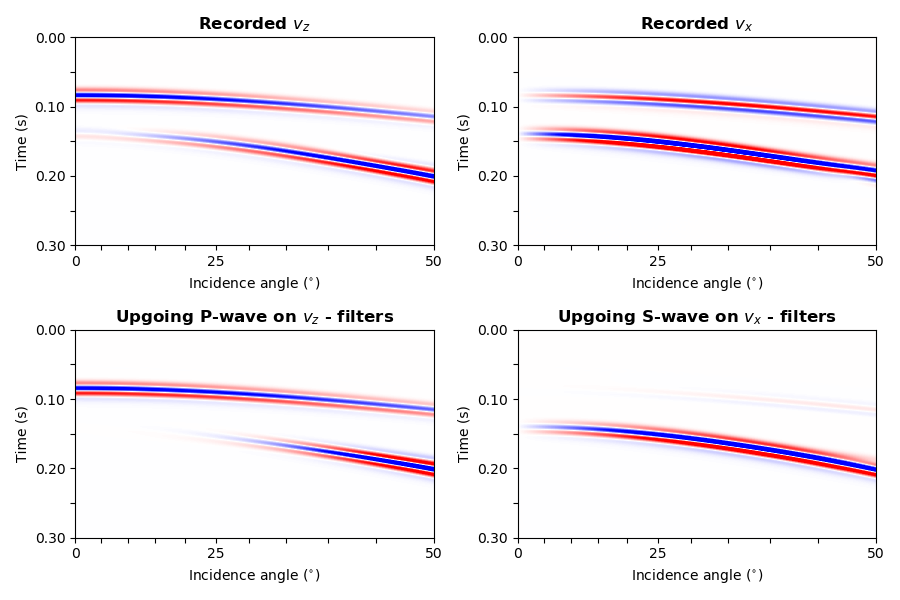

In [71]:
# plotting configuration 
# ----------------------
plt.figure(figsize=(9, 6))

# recorded vz
plt.subplot(2,2,1)
vm1 = np.percentile(vz, 99)
plt.imshow(-vz, cmap="bwr", vmin=-vm1, vmax=vm1, aspect='auto')
plt.xlim(1000,1477)
plt.ylim(60000,0)
plt.title('Recorded $v_z$',fontweight="bold")
plt.xlabel('Incidence angle ($^{\circ}$)')
plt.ylabel('Time (s)')
plt.xticks([1000,1035,1071,1107,1146,1187,1231,1280,1336,1400,1477],['0','','','','','25','','','','','50'])
plt.yticks([1,10000,20000,30000,40000,50000,60000],['0.00','','0.10','','0.20','','0.30'])

# P/S separated upgoing vz
plt.subplot(2,2,3)
vm2 = np.percentile(vz_P_up, 99)
plt.imshow(-vz_P_up, cmap="bwr", vmin=-vm2, vmax=vm2, aspect='auto')
plt.xlim(1000,1477)
plt.ylim(60000,0)
plt.title('Upgoing P-wave on $v_z$ - filters',fontweight="bold")
plt.xlabel('Incidence angle ($^{\circ}$)');
plt.ylabel('Time (s)')
plt.xticks([1000,1035,1071,1107,1146,1187,1231,1280,1336,1400,1477],['0','','','','','25','','','','','50'])
plt.yticks([1,10000,20000,30000,40000,50000,60000],['0.00','','0.10','','0.20','','0.30'])

# recorded vx
plt.subplot(2,2,2)
# imagesc(vx); caxis([-1 1]/4e8)
vm3 = np.percentile(vx, 99)
plt.imshow(-vx, cmap="bwr", vmin=-vm3, vmax=vm3, aspect='auto')
plt.xlim(1000,1477)
plt.ylim(60000,0)
plt.title('Recorded $v_x$',fontweight="bold")
plt.xlabel('Incidence angle ($^{\circ}$)')
plt.ylabel('Time (s)')
plt.xticks([1000,1035,1071,1107,1146,1187,1231,1280,1336,1400,1477],['0','','','','','25','','','','','50'])
plt.yticks([1,10000,20000,30000,40000,50000,60000],['0.00','','0.10','','0.20','','0.30'])

# P/S separated upgoing vx
plt.subplot(2,2,4)
vm4 = np.percentile(vx_S_up, 99)
plt.imshow(-vx_S_up, cmap="bwr", vmin=-vm4, vmax=vm4, aspect='auto')
plt.xlim(1000,1477)
plt.ylim(60000,0)
plt.title('Upgoing S-wave on $v_x$ - filters',fontweight="bold")
plt.xlabel('Incidence angle ($^{\circ}$)')
plt.ylabel('Time (s)')
plt.xticks([1000,1035,1071,1107,1146,1187,1231,1280,1336,1400,1477],['0','','','','','25','','','','','50'])
plt.yticks([1,10000,20000,30000,40000,50000,60000],['0.00','','0.10','','0.20','','0.30'])

# show result on screen
plt.tight_layout()
plt.show()